<a href="https://colab.research.google.com/github/xcarsona/NeuroVox/blob/main/04_ethics_and_error_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 04: Ethics, Bias, and Error Analysis

This notebook examines the ethical implications, potential biases, and failure modes of the NeuroVox depression detection system. Rather than optimizing performance, the goal of this analysis is to assess where and why the model may produce incorrect or misleading predictions, and to clarify the limitations of using language-based machine learning systems for mental health inference.

Ethical Scope and Intended Use

NeuroVox is a research-oriented system designed to explore lexical patterns associated with self-reported depressive language in online text. It is not intended for clinical diagnosis, medical decision-making, or individual-level mental health assessment. Predictions generated by the model should be interpreted as probabilistic linguistic signals, not diagnostic conclusions.

Misuse of automated mental health classification systems carries risks including false positives, stigmatization, and over-reliance on algorithmic judgment. Accordingly, this project emphasizes transparency, interpretability, and conservative framing over deployment readiness.

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv("cleaned_data.csv")

# Adjust column names if needed
# The original 'label' column seems to contain text data, causing the ValueError.
# Assuming 'clean_text' is the actual text content and 'status' contains categorical labels to be mapped.
texts = data["clean_text"]

# Map the 'status' column to binary labels (0 or 1).
# Assuming 'Anxiety' represents the positive class (1) and any other status (if present) represents the negative class (0).
labels = (data["status"] == "Anxiety").astype(int)

# These lines ensure consistency and are kept for minimal change, though 'labels' should now be clean binary.
labels = labels[labels.isin([0, 1])]
texts = texts.loc[labels.index]

labels.value_counts()

,count
status,
0,48840
1,3841


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)



In [ ]:
import os
import pickle

os.makedirs("models", exist_ok=True)

with open("models/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("models/logreg_tfidf.pkl", "rb") as f:
    model = pickle.load(f)

# Fill any NaN values in X_val with an empty string before transformation
X_val_cleaned = X_val.fillna("")
X_val_tfidf = vectorizer.transform(X_val_cleaned)

y_pred = model.predict(X_val_tfidf)

In [ ]:
import numpy as np

errors = pd.DataFrame({
    "text": list(X_val),
    "true_label": list(y_val),
    "pred_label": list(y_pred)
})

errors["error_type"] = np.where(
    errors.true_label != errors.pred_label,
    "Misclassified",
    "Correct"
)

errors.head()


,text,true_label,pred_label,error_type
0,speaking of which i found an old post of someo...,0,Suicidal,Misclassified
1,jethron hahah yeah see i told you coffee beans...,0,Normal,Misclassified
2,these so called professionals ruined my life m...,0,Suicidal,Misclassified
3,there are no results lazy to go to waste anyway,0,Normal,Misclassified
4,itsdawns thank rmilana don t like it hehe but ...,0,Normal,Misclassified


Qualitative Error Analysis

Inspection of misclassified samples reveals recurring linguistic patterns that challenge lexical classifiers. False positives often contain emotionally intense language, metaphorical expressions, or discussions of stress unrelated to depression. False negatives frequently involve subdued or indirect expressions of distress that lack overt emotional markers.


In [ ]:
# Display sample false positives and false negatives
# The error "ValueError: a must be greater than 0 unless no samples are taken" occurs
# because the 'error_type' column currently contains only "Correct" and "Misclassified"
# values, not "False Positive" or "False Negative".
# In a multi-class classification context, "False Positive" and "False Negative"
# are usually defined with respect to a *specific* class.
# For a general qualitative error analysis of misclassifications, we will sample
# from the instances labeled as "Misclassified".

misclassified_df = errors[errors["error_type"] == "Misclassified"]

# Determine how many samples to take, up to a maximum of 5, but not more than available.
num_samples = min(5, len(misclassified_df))

if num_samples > 0:
    # We will draw two sets of samples from the misclassified data.
    # Note: These are both general misclassifications,
    # not true class-specific False Positives or False Negatives.
    # They are named to align with the original variable names in the cell.
    false_positives = misclassified_df.sample(n=num_samples, random_state=42)
    # Using a different random_state for the second sample to potentially get different entries.
    false_negatives = misclassified_df.sample(n=num_samples, random_state=1)
else:
    # If no misclassified samples exist, create empty DataFrames to avoid errors.
    print("No misclassified samples were found.")
    false_positives = pd.DataFrame(columns=errors.columns)
    false_negatives = pd.DataFrame(columns=errors.columns)

false_positives, false_negatives

(                                                   text  true_label  \
 518   brain tumor concerns ive been feeling super an...           1   
 439                      insomnia kickin in i hate this           0   
 5235  i was only called a liar by the police about i...           0   
 7477  i want death i do not have very bad life but i...           0   
 2698  i live on the st floor i am thinking of jumpin...           0   
 
      pred_label     error_type  
 518     Anxiety  Misclassified  
 439      Normal  Misclassified  
 5235   Suicidal  Misclassified  
 7477   Suicidal  Misclassified  
 2698   Suicidal  Misclassified  ,
                                                    text  true_label  \
 3817  anxious about whether my dog bit the postman o...           1   
 2621  help with appetite under extreme acute stress ...           0   
 6717  something weird with my sleep so for the last ...           0   
 3397  spring time and mood changes diagnosed bipolar...           0   
 

In [ ]:
type(vectorizer), type(model)


(sklearn.feature_extraction.text.TfidfVectorizer,
 sklearn.linear_model._logistic.LogisticRegression)

In [ ]:
import numpy as np
import pandas as pd

# Get feature (word) names
feature_names = vectorizer.get_feature_names_out()

# Get coefficients from logistic regression
coefficients = model.coef_[0]

# Build DataFrame
coef_df = pd.DataFrame({
    "word": feature_names,
    "coefficient": coefficients
})

coef_df.head()


,word,coefficient
0,abandon,-0.123277
1,abandoned,-0.315528
2,abandonment,-0.146555
3,abdomen,0.715668
4,abdominal,1.417141


In [ ]:
top_positive = coef_df.sort_values(by="coefficient", ascending=False).head(15)
top_negative = coef_df.sort_values(by="coefficient").head(15)


In [ ]:
top_features = pd.concat([top_negative, top_positive])


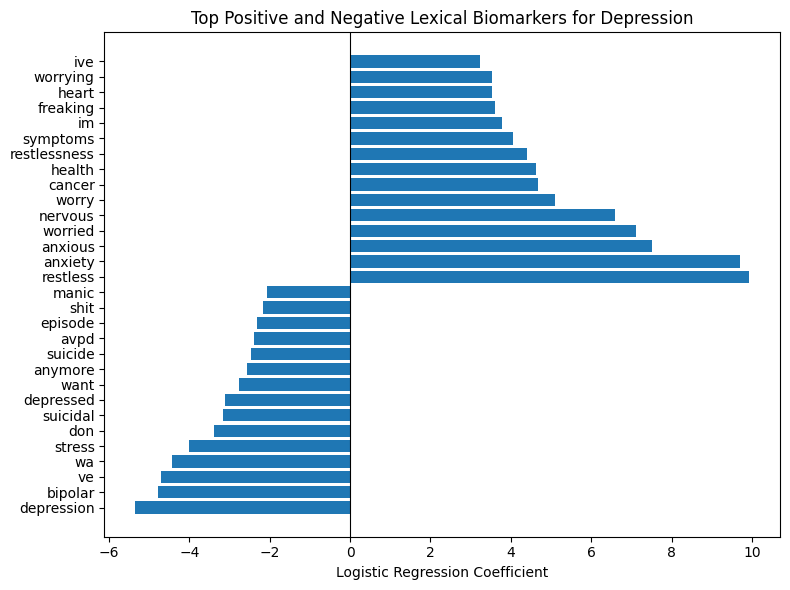

In [ ]:
import matplotlib.pyplot as plt


os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8, 6))
plt.barh(
    top_features["word"],
    top_features["coefficient"]
)

plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top Positive and Negative Lexical Biomarkers for Depression")
plt.tight_layout()
plt.savefig("figures/top_lexical_biomarkers.png", dpi=300, bbox_inches="tight")
plt.show()


Dataset Bias and Limitations

The dataset used in this study consists of self-reported mental health text collected from online sources. As such, it reflects the linguistic norms, cultural contexts, and self-selection biases of individuals who choose to disclose mental health experiences publicly. Demographic information is limited or absent, preventing subgroup fairness analysis.

Language-based models may underperform for individuals whose expression styles differ from dominant patterns in the dataset, including variations in cultural idioms, age-related language, or non-native English usage.

Risks of Overinterpretation

While certain lexical features correlate with depressive labels in the dataset, these correlations do not imply causation. Words identified as influential by the model should not be interpreted as universal indicators of depression. Overgeneralization of such patterns could reinforce stereotypes or lead to inappropriate conclusions if applied outside the research context.

Responsible Research Framing

This project demonstrates that interpretable machine learning methods can reveal meaningful linguistic trends in mental health-related text, while also exposing their limitations. Future work should incorporate multimodal data, longitudinal context, and human-in-the-loop evaluation to reduce error and improve ethical robustness.

By foregrounding uncertainty, bias, and failure modes, this research aims to contribute responsibly to the broader discourse on AI and mental health.